<a href="https://colab.research.google.com/github/LimaCondas/eco-driving-speed-rl/blob/main/My_Gym01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**0.Install Dependencies**

---



In [ ]:
!pip install gym
!pip install tensorflow==2.5.0
!pip install keras
!pip install keras-rl2


# **1. Test a Simple Eco-Driving Scenario**


---




> **import packages**

In [ ]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

> **Define Constants**

In [ ]:
# This code defines several constants that can be used in a physics model for a car
# VEHICLE_MASS is set to 1500KG, representing the mass of a vehicle in kilograms
VEHICLE_MASS = 1500

# GRAVITY is set to 9.8, representing the acceleration due to gravity in meters per second squared
GRAVITY = 9.8

# INIT_VELOCITY is set to 60KM/H, representing the initial velocity of a vehicle in meters per second
INIT_VELOCITY = 60

# INIT_ACC is set to 0M/S^2, representing the initial acceleration 
INIT_ACC= 0

# SAFETY_DISTANCE is set to 20M, representing the distance a car should maintain from the car in front of it in meters
SAFETY_DISTANCE = 20

# SPEED_LIMIT is set to 60KM/H, representing the maximum speed limit in the area the model is being applied to in meters per second
SPEED_LIMIT = 60

# DISTANCE is set to 10KM, representing the total distance of the given virtual road environment
DISTANCE = 10


>**Code to define the work of fraction force**

In [ ]:
# Constants
MASS = 1000 # kg
GRAVITY = 9.81 # m/s^2
MAX_SPEED = 20 # m/s

# Initial conditions
v = 10 # m/s
a = 2 # m/s^2
t = 0 # s
dt = 0.1 # s

# Calculate the work done by the traction force
work = 0
while v > 0 and v < MAX_SPEED:
    F_traction = MASS * a
    work += F_traction * v * dt
    v = v + a * dt
    t = t + dt

print("Work done by the traction force: {:.2f} J".format(work))

> **This block is EcoDrivingEnv finished by ChatGPT**

In [67]:
import gym
from gym import spaces
import numpy as np
import random

class EcoDrivingEnv(gym.Env):
    def __init__(self):
        self.safe_speed_limit = 60 # m/s
        self.time_step = 0.1 # seconds
        self.mass = 1000 # kg
        self.gravity = 9.81 # m/s^2
        self.MAX_SPEED = 100 # m/s
        self.friction_coefficient = 0.8
        self.position = 0
        self.speed = 0
        self.work = 0
        self.steps = 0
        self.total_reward = 0
        self.track_length = 1000
        self.max_steps = 500
        self.max_acceleration = 1

        self.action_space = spaces.Discrete(3) # deaccelerate, no action, accelerate
        # Observation space [position, speed]
        self.observation_space = spaces.Box(low=np.array([0, 0]), high=np.array([np.inf, np.inf]), dtype=np.float32)
        print("Successfully Initialize EcoDrivingEnv.......")

    def reset(self):
        self.position = 0
        self.speed = 0
        self.work = 0
        self.steps = 0
        self.total_reward = 0
        return np.array([self.position, self.speed], dtype=np.float32)

    def step(self, action):
        # Apply action
        if action == 0:
            acceleration = -self.max_acceleration # -1
        elif action == 1:
            acceleration = 0
        else:
            acceleration = self.max_acceleration # 1

        # Calculate new speed and position
        new_speed = self.speed + acceleration * self.time_step # vt = v0 + a * dt
        new_speed = np.clip(new_speed, 0, self.MAX_SPEED) # speed no bigger than max speed
        # xt = x0 + vt + 0.5 * a * t^2
        new_position = self.position + self.speed * self.time_step + 0.5 * acceleration * self.time_step ** 2

        # Calculate work of friction force
        friction_force = self.friction_coefficient * 1000 * acceleration # F = 0.8 * m * a
        friction_work = friction_force * (new_position - self.position) # W = F * dx

        # Calculate deviation from safe speed limit
        speed_deviation = abs(new_speed - self.safe_speed_limit)

        # Calculate reward
        reward = - 0.3 * friction_work - 0.7 * speed_deviation

        # Update state
        self.position = new_position
        self.speed = new_speed
        self.steps += 1

        # Check if episode is done, distance or steps satisfied
        done = False
        if self.position >= self.track_length or self.steps >= self.max_steps:
          done = True

        # Update info dictionary with additional information
        self.state = np.array([self.position, self.speed], dtype=np.float32)
        info = {'friction_work': friction_work, 'speed_deviation': speed_deviation}

        # Return step information
        return self.state, reward, done, info


    def render(self):
        # print(f"Position: {self.position:.2f}m, Speed: {self.speed:.2f}m/s, Work: {self.work:.2f}J, Steps: {self.steps}")
        pass

> **Examplify an Eco-Drving Env**

In [68]:
env = EcoDrivingEnv()

Successfully Initialize EcoDrivingEnv.......


> **Test Environment with Random Action**

In [44]:
# env.action_space.sample()
# env.observation_space.sample()

In [69]:
episode = 10

flag = 0
position = []
speed = []

for episode in range(1, episode+1):
  state = env.reset()
  done = False
  score = 0
  
  while not done:
    action = random.choice([0, 1, 2])
    n_state, reward, done, info = env.step(action)
    score += reward

    if not flag:
      position.append(n_state[0])
      speed.append(n_state[1])
  flag = 1

  print('===== Episode:{} Score:{} ====='.format(episode, int(score)))


===== Episode:1 Score:-20736 =====
===== Episode:2 Score:-20974 =====
===== Episode:3 Score:-20925 =====
===== Episode:4 Score:-20975 =====
===== Episode:5 Score:-20572 =====
===== Episode:6 Score:-20992 =====
===== Episode:7 Score:-21014 =====
===== Episode:8 Score:-21702 =====
===== Episode:9 Score:-20508 =====
===== Episode:10 Score:-20873 =====


> **SAMPLE to plot the profile of position and speed in 1 episode**

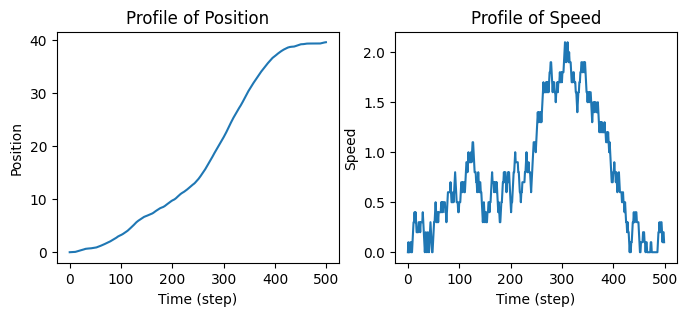

In [75]:
import matplotlib.pyplot as plt
import numpy as np

position_data = position
speed_data = speed

# Create a figure with 2 subplots for position and speed
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
fig.subplots_adjust(hspace=0.4)

# Plot position data
ax1.plot(position_data, '-')
ax1.set_title('Profile of Position')
ax1.set_xlabel('Time (step)')
ax1.set_ylabel('Position')

# Plot speed data
ax2.plot(speed_data, '-')
ax2.set_title('Profile of Speed')
ax2.set_xlabel('Time (step)')
ax2.set_ylabel('Speed')

# Display the plot
plt.show()


# **2. Create a Deep Learning Model with Keras**


---



In [78]:
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [80]:
states = env.observation_space.shape
actions = env.action_space.n

In [83]:
states

(2,)

In [85]:
def build_model(states, actions):
  model = Sequential()
  model.add(Dense(24, activation='Relu', input_shape=states))
  model.add(Dense(24, activation='Relu'))
  model.add(Dense(actions, activation='linear'))
  return model



> **This code block is DQN model generated by ChatGPT**



In [ ]:
import gym
import random
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

EPISODES = 1000
MEMORY_SIZE = 1000000
BATCH_SIZE = 64
GAMMA = 0.95
LEARNING_RATE = 0.001
EPSILON = 1.0
EPSILON_DECAY = 0.995
MIN_EPSILON = 0.01

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=LEARNING_RATE))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, epsilon):
        if np.random.rand() <= epsilon:
            return np.random.choice(self.action_size)
        else:
            return np.argmax(self.model.predict(state)[0])

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        states, targets = [], []
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)
            if done:
                target[0][action] = reward
            else:
                target[0][action] = reward + GAMMA * np.amax(self.target_model.predict(next_state)[0])
            states.append(state[0])
            targets.append(target[0])
        self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

def train_dqn(env):
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    done = False
    for episode in range(EPISODES):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        done = False
        total_reward = 0
        while not done:
            action = agent.act(state, EPSILON)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if len(agent.memory) > BATCH_SIZE:
                agent.replay()
                agent.update_target_model()
        EPSILON = max(MIN_EPSILON, EPSILON_DECAY * EPSILON)
        print("Episode: %d, Total Reward: %d" % (episode, total_reward))
        if episode % 50 == 0:
            agent.save("dqn_model.h5")

if __name__ == "__"


SyntaxError: ignored

> Code using pygame to display a straight road with single vehicle on it. 

> **WARNING: Cannot run in Colab**

In [ ]:
import pygame

# Initialize Pygame
pygame.init()

# Set up the display
screen_width = 800
screen_height = 600
screen = pygame.display.set_mode((screen_width, screen_height))
pygame.display.set_caption("Simple Car Game")

# Colors
black = (0, 0, 0)
white = (255, 255, 255)
gray = (128, 128, 128)
green = (0, 200, 0)

# Set up the road
road_width = 600
road_height = 100
road_x = (screen_width - road_width) / 2
road_y = screen_height - road_height - 200
road_rect = pygame.Rect(road_x, road_y, road_width, road_height)

# Set up the car
car_width = 50
car_height = 30
car_x = (screen_width - car_width) / 2 - 250
car_y = screen_height - car_height - 210
car_rect = pygame.Rect(car_x, car_y, car_width, car_height)


# Game loop
running = True
while running:
    # Handle events
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Clear the screen
    screen.fill(white)

    # Draw the road
    pygame.draw.rect(screen, gray, road_rect)
    pygame.draw.line(screen, white, (road_x, road_y + road_height/2), (road_x + road_width, road_y + road_height/2), 5)

    # Draw the car shade
    car_shade_surf = pygame.Surface((car_width, car_height))
    car_shade_surf.set_alpha(100)  # Set the alpha value for transparency
    car_shade_surf.fill((0, 0, 0))  # Fill the surface with black
    screen.blit(car_shade_surf, (car_x-3, car_y-3))  # Blit the surface onto the screen

    # Draw the car
    pygame.draw.rect(screen, green, car_rect)

    # Update the display
    pygame.display.update()

# Quit Pygame
pygame.quit()


error: ignored